# Canny Edge Detection in Programmable Logic (PL)

Canny Edge Detection in Programmable Logic
(Replace Resize IP with Canny IP Mentally)

<img src="./images/resize_bd.png" width="800" height="650"/>

## Import libraries

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay
import time
import cv2

## Download the Canny IP bitstream

After the bitstream has been downloaded, the PL will be populated with
the resize IP, the DMA engine.

In [2]:
canny_design = Overlay("canny.bit")

In [3]:
canny_design.ip_dict

{'axi_dma_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0xaf7b6c70>,
  'driver': pynq.lib.dma.DMA,
  'fullpath': 'axi_dma_0',
  'gpio': {},
  'interrupts': {},
  'mem_id': 'S_AXI_LITE',
  'parameters': {'C_BASEADDR': '0x40400000',
   'C_DLYTMR_RESOLUTION': '125',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_FAMILY': 'zynq',
   'C_HIGHADDR': '0x4040FFFF',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_DRE': '0',
   'C_INCLUDE_S2MM_SF': '1',
   'C_INCLUDE_SG': '0',
   'C_INCREASE_THROUGHPUT': '0',
   'C_MICRO_DMA': '0',
   'C_MM2S_BURST_SIZE': '256',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXI_S2MM_ADDR_WIDTH': '32',
   'C_M_AXI_S2MM_DATA_WIDTH': '32',
   'C_M_AXI_SG_ADDR_WIDTH': '32',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2M

Then create DMA and Canny IP objects. (Replace Resize IP with Canny IP Mentally)

In [4]:
dma = canny_design.axi_dma_0
ctrl = canny_design.canny_edge_detection_0


<img src="./images/resize_bit.png" width="600" height="450"/>


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

Image By Aboubakrhadnine - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=79587474">Link</a>.

In [5]:
image_path = "images/lenna.png"
image = Image.open(image_path)

(Replace Resize IP with Canny IP Mentally)
<img src="images/sd2dram.png" width="650" height="550"/>

## Display the image

Image size: 512x512 pixels.


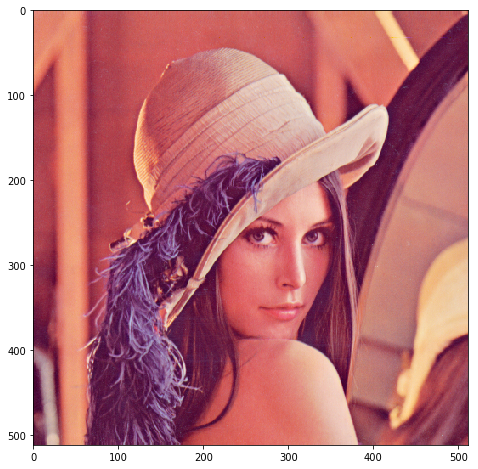

In [6]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = image.size
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(image)


We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `cma_array()` to perform the allocation.

In [7]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(height, width, 3), dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(height, width, 3), dtype=np.uint8, cacheable=1)

Documentation snippet for `xlnk.cma_array`:

```python
"""
Get a contiguously allocated numpy array

Parameters
----------
shape : int or tuple of int
    The dimensions of the array to construct - We use (height, width, depth)
dtype : numpy.dtype or str
    The data type to construct - We use 8-bit unsigned int

"""
```

Note that the original image has to be copied into the contiguous memory array (deep copy).
(Replace the Resize IP with Canny IP mentally)
<img src="./images/local2shared.png" width="650" height="550"/>

In [8]:
in_buffer[:] = np.array(image)

We can now run the Canny Edge Detection IP.
We will push the data from input buffer through the pipeline to the output buffer.
For ease-of-use, we will define a `run_kernel` function that will be called 
multiple times. (Same as before, replace Resize IP with Canny IP mentally)

<img src="./images/resize_accel.png" width="650" height="550"/>

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    ctrl.write(0x0,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()


We will also need to do some setup with the MMIO interface 
With this IP, we will need to define both High and Low Hysteris Thresholds  

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | Hysteresis Low                         |
| 0x18            | Hysteresis High                        |

In [10]:
ctrl.write(0x10, 90)
ctrl.write(0x18, 10)

Now we can perform the resizing operation.

In [11]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## Display detected edges

Image size: 512x512 pixels.


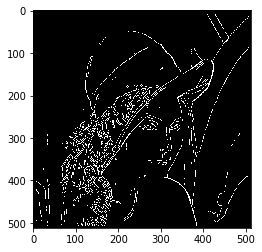

In [12]:
processed_image = Image.fromarray(out_buffer)
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(processed_image)
processed_image.save("images/out.png")

We can time the resize in PL operation.

Finally we need to reset all the contiguous memory buffers.

In [13]:
xlnk.xlnk_reset()

[Contents](#Contents)

# References

https://github.com/Xilinx/PYNQ-HelloWorld  

https://github.com/medalotte/HLS-canny-edge-detection